In [ ]:
from torchvision import datasets

In [7]:
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=None)

100.1%Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
113.5%Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
100.4%Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
180.4%Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [10]:
dataset1

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [45]:
dataset2 = datasets.MNIST('./data', train=False, download=True, transform=None)

In [46]:
dataset2

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [13]:
dir(dataset1)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [17]:
import matplotlib.pyplot as plt


In [47]:
print("data count:", len(dataset1.data))
print("test data count:", len(dataset1.test_data))
print("train data count:", len(dataset1.train_data))
print("train label count:", dataset1.train_labels)
print(dataset1.classes)
print("============ test set =============")
print("data count:", len(dataset2.data))
print("test data count:", len(dataset2.test_data))
print("train data count:", len(dataset2.train_data))
print("train label count:", dataset2.train_labels)
print(dataset1.classes)


data count: 60000
test data count: 60000
train data count: 60000
train label count: tensor([5, 0, 4,  ..., 5, 6, 8])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
============ test set =============
data count: 10000
test data count: 10000
train data count: 10000
train label count: tensor([7, 2, 1,  ..., 4, 5, 6])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


tensor(6)


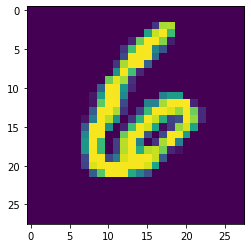

In [49]:
print(dataset1.train_labels[13])
plt.imshow(dataset1.data[13])

tensor(0)


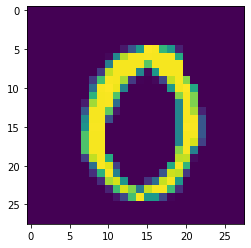

In [50]:
print(dataset2.train_labels[13])
plt.imshow(dataset2.data[13])